In [1]:
import re
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
def select_gpu(N):
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print(gpus)
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            tf.config.experimental.set_visible_devices(gpus[N], 'GPU')
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)    

In [3]:
select_gpu(2)
epochs = 512
batch_size = 1024
model_name = 'bert-chinese'
embedding_path = '/home/Danny/pretrain_model/{}'.format(model_name)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
3 Physical GPUs, 1 Logical GPUs


In [4]:
# 不用儲存article_id, 轉成list
def training_txt_to_list(path):
    with open(path, 'r') as f:
        txt = str(f.read())
    txt_list = txt.split('\n')
    text_label_list = list()
    tmp = list()
    for line in txt_list:
        if line == '--------------------':
            text_label_list.append(tmp)
            tmp = list()
            continue
        if line == '':
            continue
        tmp.append(line)
    x = list()
    y = list()
    for text_label in text_label_list:
        text = text_label[0]
        label = text_label[2:]
        label_list = ['O' for i in range(len(text))]
        for i in label:
            entity = i.split('\t')
            if int(entity[1]) > int(entity[2]):
                continue
            b = int(entity[1])
            label_list[b] = 'B-{}'.format(entity[-1])
            for j in range(int(entity[1])+1, int(entity[2])):
                label_list[j] = 'I-{}'.format(entity[-1])
        for i, j in enumerate(text):
            if j == '，' or j == '。' or j == '？':
                label_list[i] = j
                
        text_list = re.split('\uff0c|\u3002|\uff1f', text)
        for sentence in text_list:
            x.append([i for i in sentence])
        x = x[:-1]
            
        sentence = list()
        for i in label_list:
            if i == '，' or i == '。' or i == '？':
                y.append(sentence)
                sentence = list()
            else:
                sentence.append(i)
                
    return [x, y]

In [5]:
x1, y1 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage1/SampleData_deid.txt')

In [6]:
x2, y2 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage2/train_1_update.txt')

In [7]:
x4, y4 = training_txt_to_list('/home/Danny/AI-CUP-2020/datasets/stage4/train_2.txt')

In [8]:
x = x1 + x2 + x4
y = y1 + y2 + y4
print(len(x))
print(len(y))

76162
76162


In [9]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
print(len(train_x), len(train_y))
print(len(valid_x), len(valid_y))
print(len(test_x), len(test_y))

48743 48743
12186 12186
15233 15233


In [10]:
%%time
import kashgari
from kashgari.tasks.labeling import BiLSTM_CRF_Model
from kashgari.embeddings import BertEmbedding
kashgari.config.use_cudnn_cell = True
bert_embedding = BertEmbedding(embedding_path, 
                           sequence_length='auto',
                           trainable=True,
                           task='kashgari.LABELING', 
                          )
model = BiLSTM_CRF_Model(bert_embedding)
history = model.fit(train_x,
                    train_y,
                    valid_x,
                    valid_y,
                    epochs=epochs,
                    batch_size=batch_size,
                   )

2020-12-14 13:20:05,914 [DEBUG] kashgari - ------------------------------------------------
2020-12-14 13:20:05,915 [DEBUG] kashgari - Loaded transformer model's vocab
2020-12-14 13:20:05,915 [DEBUG] kashgari - config_path       : /home/Danny/pretrain_model/bert-chinese/bert_config.json
2020-12-14 13:20:05,916 [DEBUG] kashgari - vocab_path      : /home/Danny/pretrain_model/bert-chinese/vocab.txt
2020-12-14 13:20:05,916 [DEBUG] kashgari - checkpoint_path : /home/Danny/pretrain_model/bert-chinese/bert_model.ckpt
2020-12-14 13:20:05,917 [DEBUG] kashgari - Top 50 words    : ['[PAD]', '[unused1]', '[unused2]', '[unused3]', '[unused4]', '[unused5]', '[unused6]', '[unused7]', '[unused8]', '[unused9]', '[unused10]', '[unused11]', '[unused12]', '[unused13]', '[unused14]', '[unused15]', '[unused16]', '[unused17]', '[unused18]', '[unused19]', '[unused20]', '[unused21]', '[unused22]', '[unused23]', '[unused24]', '[unused25]', '[unused26]', '[unused27]', '[unused28]', '[unused29]', '[unused30]', '[

Epoch 1/512
47/47 [==============================] - 43s 913ms/step - loss: 1.9720 - accuracy: 0.9187 - val_loss: 26.4777 - val_accuracy: 0.6618
Epoch 2/512
47/47 [==============================] - 41s 867ms/step - loss: 0.4904 - accuracy: 0.9782 - val_loss: 26.4248 - val_accuracy: 0.6704
Epoch 3/512
47/47 [==============================] - 41s 878ms/step - loss: 0.3628 - accuracy: 0.9815 - val_loss: 26.2859 - val_accuracy: 0.6749
Epoch 4/512
47/47 [==============================] - 43s 909ms/step - loss: 0.2920 - accuracy: 0.9836 - val_loss: 26.2272 - val_accuracy: 0.6783
Epoch 5/512
47/47 [==============================] - 42s 899ms/step - loss: 0.2467 - accuracy: 0.9854 - val_loss: 26.1766 - val_accuracy: 0.6794
Epoch 6/512
47/47 [==============================] - 44s 928ms/step - loss: 0.2160 - accuracy: 0.9869 - val_loss: 26.1261 - val_accuracy: 0.6805
Epoch 7/512
47/47 [==============================] - 42s 889ms/step - loss: 0.1961 - accuracy: 0.9877 - val_loss: 26.1024 - val_ac

47/47 [==============================] - 46s 971ms/step - loss: 0.0187 - accuracy: 0.9984 - val_loss: 24.5611 - val_accuracy: 0.0570
Epoch 58/512
47/47 [==============================] - 47s 1s/step - loss: 0.0178 - accuracy: 0.9985 - val_loss: 24.5144 - val_accuracy: 0.0541
Epoch 59/512
47/47 [==============================] - 47s 1s/step - loss: 0.0175 - accuracy: 0.9985 - val_loss: 24.5177 - val_accuracy: 0.0542
Epoch 60/512
47/47 [==============================] - 48s 1s/step - loss: 0.0199 - accuracy: 0.9983 - val_loss: 24.5197 - val_accuracy: 0.0524
Epoch 61/512
47/47 [==============================] - 48s 1s/step - loss: 0.0179 - accuracy: 0.9985 - val_loss: 24.4789 - val_accuracy: 0.0535
Epoch 62/512
47/47 [==============================] - 48s 1s/step - loss: 0.0162 - accuracy: 0.9987 - val_loss: 24.4819 - val_accuracy: 0.0522
Epoch 63/512
47/47 [==============================] - 51s 1s/step - loss: 0.0151 - accuracy: 0.9988 - val_loss: 24.4436 - val_accuracy: 0.0520
Epoch 64/

Epoch 114/512
47/47 [==============================] - 41s 874ms/step - loss: 0.0080 - accuracy: 0.9992 - val_loss: 23.4834 - val_accuracy: 0.0185
Epoch 115/512
47/47 [==============================] - 41s 866ms/step - loss: 0.0080 - accuracy: 0.9991 - val_loss: 23.4732 - val_accuracy: 0.0180
Epoch 116/512
47/47 [==============================] - 40s 855ms/step - loss: 0.0085 - accuracy: 0.9990 - val_loss: 23.4916 - val_accuracy: 0.0187
Epoch 117/512
47/47 [==============================] - 40s 847ms/step - loss: 0.0085 - accuracy: 0.9990 - val_loss: 23.4217 - val_accuracy: 0.0183
Epoch 118/512
47/47 [==============================] - 40s 843ms/step - loss: 0.0074 - accuracy: 0.9992 - val_loss: 23.4553 - val_accuracy: 0.0185
Epoch 119/512
47/47 [==============================] - 40s 846ms/step - loss: 0.0073 - accuracy: 0.9992 - val_loss: 23.4173 - val_accuracy: 0.0177
Epoch 120/512
47/47 [==============================] - 40s 844ms/step - loss: 0.0083 - accuracy: 0.9991 - val_loss: 23

Epoch 170/512
47/47 [==============================] - 40s 861ms/step - loss: 0.0062 - accuracy: 0.9992 - val_loss: 22.1305 - val_accuracy: 0.0155
Epoch 171/512
47/47 [==============================] - 40s 853ms/step - loss: 0.0060 - accuracy: 0.9992 - val_loss: 22.1001 - val_accuracy: 0.0152
Epoch 172/512
47/47 [==============================] - 40s 855ms/step - loss: 0.0056 - accuracy: 0.9991 - val_loss: 22.1138 - val_accuracy: 0.0150
Epoch 173/512
47/47 [==============================] - 40s 857ms/step - loss: 0.0073 - accuracy: 0.9989 - val_loss: 22.0699 - val_accuracy: 0.0151
Epoch 174/512
47/47 [==============================] - 41s 864ms/step - loss: 0.0056 - accuracy: 0.9992 - val_loss: 22.0208 - val_accuracy: 0.0152
Epoch 175/512
47/47 [==============================] - 40s 858ms/step - loss: 0.0064 - accuracy: 0.9991 - val_loss: 21.9569 - val_accuracy: 0.0155
Epoch 176/512
47/47 [==============================] - 41s 871ms/step - loss: 0.0063 - accuracy: 0.9991 - val_loss: 21

Epoch 226/512
47/47 [==============================] - 39s 836ms/step - loss: 0.0048 - accuracy: 0.9993 - val_loss: 20.6446 - val_accuracy: 0.0141
Epoch 227/512
47/47 [==============================] - 39s 837ms/step - loss: 0.0047 - accuracy: 0.9993 - val_loss: 20.6398 - val_accuracy: 0.0141
Epoch 228/512
47/47 [==============================] - 39s 836ms/step - loss: 0.0044 - accuracy: 0.9993 - val_loss: 20.6307 - val_accuracy: 0.0137
Epoch 229/512
47/47 [==============================] - 40s 843ms/step - loss: 0.0043 - accuracy: 0.9993 - val_loss: 20.5654 - val_accuracy: 0.0138
Epoch 230/512
47/47 [==============================] - 39s 837ms/step - loss: 0.0046 - accuracy: 0.9992 - val_loss: 20.5843 - val_accuracy: 0.0139
Epoch 231/512
47/47 [==============================] - 39s 839ms/step - loss: 0.0042 - accuracy: 0.9994 - val_loss: 20.5529 - val_accuracy: 0.0140
Epoch 232/512
47/47 [==============================] - 39s 836ms/step - loss: 0.0049 - accuracy: 0.9992 - val_loss: 20

Epoch 282/512
47/47 [==============================] - 39s 836ms/step - loss: 0.0040 - accuracy: 0.9993 - val_loss: 19.4632 - val_accuracy: 0.0142
Epoch 283/512
47/47 [==============================] - 39s 836ms/step - loss: 0.0041 - accuracy: 0.9993 - val_loss: 19.4633 - val_accuracy: 0.0140
Epoch 284/512
47/47 [==============================] - 39s 835ms/step - loss: 0.0040 - accuracy: 0.9993 - val_loss: 19.4475 - val_accuracy: 0.0139
Epoch 285/512
47/47 [==============================] - 39s 836ms/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 19.4128 - val_accuracy: 0.0137
Epoch 286/512
47/47 [==============================] - 39s 837ms/step - loss: 0.0036 - accuracy: 0.9994 - val_loss: 19.3482 - val_accuracy: 0.0136
Epoch 287/512
47/47 [==============================] - 39s 836ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 19.3681 - val_accuracy: 0.0138
Epoch 288/512
47/47 [==============================] - 39s 836ms/step - loss: 0.0037 - accuracy: 0.9994 - val_loss: 19

Epoch 338/512
47/47 [==============================] - 40s 843ms/step - loss: 0.0037 - accuracy: 0.9994 - val_loss: 18.5554 - val_accuracy: 0.0137
Epoch 339/512
47/47 [==============================] - 39s 837ms/step - loss: 0.0035 - accuracy: 0.9994 - val_loss: 18.5463 - val_accuracy: 0.0135
Epoch 340/512
47/47 [==============================] - 39s 835ms/step - loss: 0.0038 - accuracy: 0.9993 - val_loss: 18.5085 - val_accuracy: 0.0141
Epoch 341/512
47/47 [==============================] - 39s 837ms/step - loss: 0.0036 - accuracy: 0.9994 - val_loss: 18.5267 - val_accuracy: 0.0135
Epoch 342/512
47/47 [==============================] - 39s 836ms/step - loss: 0.0037 - accuracy: 0.9993 - val_loss: 18.5000 - val_accuracy: 0.0138
Epoch 343/512
47/47 [==============================] - 39s 835ms/step - loss: 0.0033 - accuracy: 0.9994 - val_loss: 18.4972 - val_accuracy: 0.0138
Epoch 344/512
47/47 [==============================] - 39s 835ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 18

Epoch 394/512
47/47 [==============================] - 39s 835ms/step - loss: 0.0037 - accuracy: 0.9993 - val_loss: 18.1188 - val_accuracy: 0.0138
Epoch 395/512
47/47 [==============================] - 39s 839ms/step - loss: 0.0040 - accuracy: 0.9993 - val_loss: 18.1118 - val_accuracy: 0.0137
Epoch 396/512
47/47 [==============================] - 39s 838ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 18.0927 - val_accuracy: 0.0138
Epoch 397/512
47/47 [==============================] - 39s 838ms/step - loss: 0.0033 - accuracy: 0.9994 - val_loss: 18.0693 - val_accuracy: 0.0139
Epoch 398/512
47/47 [==============================] - 39s 837ms/step - loss: 0.0032 - accuracy: 0.9994 - val_loss: 18.0660 - val_accuracy: 0.0138
Epoch 399/512
47/47 [==============================] - 39s 836ms/step - loss: 0.0035 - accuracy: 0.9993 - val_loss: 18.0913 - val_accuracy: 0.0138
Epoch 400/512
47/47 [==============================] - 39s 836ms/step - loss: 0.0033 - accuracy: 0.9994 - val_loss: 18

Epoch 450/512
47/47 [==============================] - 39s 837ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 17.7354 - val_accuracy: 0.0135
Epoch 451/512
47/47 [==============================] - 39s 836ms/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 17.6743 - val_accuracy: 0.0138
Epoch 452/512
47/47 [==============================] - 39s 837ms/step - loss: 0.0035 - accuracy: 0.9994 - val_loss: 17.6750 - val_accuracy: 0.0139
Epoch 453/512
47/47 [==============================] - 39s 835ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 17.6684 - val_accuracy: 0.0139
Epoch 454/512
47/47 [==============================] - 39s 836ms/step - loss: 0.0032 - accuracy: 0.9994 - val_loss: 17.6559 - val_accuracy: 0.0138
Epoch 455/512
47/47 [==============================] - 39s 836ms/step - loss: 0.0033 - accuracy: 0.9994 - val_loss: 17.6260 - val_accuracy: 0.0139
Epoch 456/512
47/47 [==============================] - 39s 837ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 17

Epoch 506/512
47/47 [==============================] - 40s 848ms/step - loss: 0.0036 - accuracy: 0.9994 - val_loss: 17.3390 - val_accuracy: 0.0130
Epoch 507/512
47/47 [==============================] - 40s 849ms/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 17.3713 - val_accuracy: 0.0130
Epoch 508/512
47/47 [==============================] - 40s 845ms/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 17.3812 - val_accuracy: 0.0127
Epoch 509/512
47/47 [==============================] - 40s 843ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 17.3412 - val_accuracy: 0.0130
Epoch 510/512
47/47 [==============================] - 40s 841ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 17.3644 - val_accuracy: 0.0128
Epoch 511/512
47/47 [==============================] - 39s 839ms/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 17.3302 - val_accuracy: 0.0132
Epoch 512/512
47/47 [==============================] - 39s 834ms/step - loss: 0.0030 - accuracy: 0.9994 - val_loss: 17

In [11]:
model.evaluate(test_x, test_y)
model_path = 'model/{}_epoch_{}_batch_{}'.format(model_name, epochs, batch_size)
model.save(model_path)

2020-12-14 19:18:40,105 [WARNING] kashgari - Sequence length is None, will use the max length of the samples, which is 65
2020-12-14 19:18:40,213 [DEBUG] kashgari - predict seq_length: None, input: (2, 15233, 65)


477/477 [==============================] - 47s 99ms/step


2020-12-14 19:19:31,655 [DEBUG] kashgari - predict output: (15233, 65)
2020-12-14 19:19:31,656 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]



                precision    recall  f1-score   support

      med_exam     0.8732    0.9254    0.8986       134
          time     0.8174    0.8770    0.8462       878
         money     0.9024    0.8605    0.8810        43
          name     0.9767    0.9545    0.9655        88
      location     0.9457    0.8529    0.8969       102
       contact     0.8667    0.7222    0.7879        18
        others     0.0000    0.0000    0.0000         1
            ID     1.0000    0.3333    0.5000         9
        family     1.0000    0.6364    0.7778        11
    profession     0.7000    0.4118    0.5185        17
clinical_event     0.0000    0.0000    0.0000         1
     education     1.0000    0.5000    0.6667         2
  organization     1.0000    1.0000    1.0000         2

     micro avg     0.8464    0.8691    0.8576      1306
     macro avg     0.8479    0.8691    0.8553      1306



2020-12-14 19:20:45,439 [INFO] kashgari - model saved to /home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese_epoch_512_batch_1024


'/home/Danny/AI-CUP-2020/Danny/kashgari/model/bert-chinese_epoch_512_batch_1024'

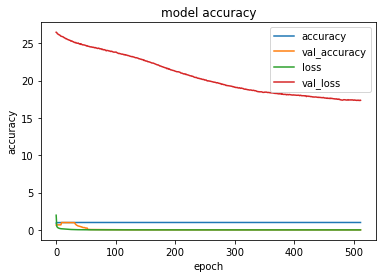

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy', 'loss', 'val_loss'])
plt.show()

In [13]:
# 需要儲存article_id, 轉成dataframe
def predicting_txt_to_dataframe(path):    
    with open(path, 'r') as f:
        txt = str(f.read())
        txt_list = txt.split('\n')
    row_list = list()
    tmp_list = list()
    for row in txt_list:
        if row == '--------------------':
            tmp_list[0] = tmp_list[0].replace('article_id:', '')
            tmp_list[0] = int(tmp_list[0])
            row_list.append(tmp_list)
            tmp_list = list()
            continue
        if len(row) > 0:
            tmp_list.append(row)
    df = pd.DataFrame(row_list, columns=['article_id','text'])
    return df

In [14]:
def predict_NER(text):
    x_list = list()    
    text_list = re.split('\uff0c|\u3002|\uff1f', text)
    for article in text_list:
        x_list.append([i for i in article])
    y_list_list = model.predict(x_list)
    y_list = list()
    for sentence in y_list_list:
        for word in sentence:
            y_list.append(word)
        y_list.append('O') # append(，。？)
    y_list = y_list[:-1]
    return y_list

In [15]:
def output_NER(article_id, text, y_list):
    output_str = str()
    flag = False
    for i, j in enumerate(y_list):
        if j != 'O':
            if j[0] == 'B':
                start_position = i
                entity_type = j.split('-')[-1]
                flag = True
        elif j == 'O' and flag == True:
            end_position = i
            flag = False
            entity_text = text[start_position: end_position]
            entity = '{}\t{}\t{}\t{}\t{}\n'.format(article_id, start_position, end_position, entity_text, entity_type)  
            output_str += entity
    return output_str

In [ ]:
df = predicting_txt_to_dataframe('/home/Danny/AI-CUP-2020/datasets/stage5/test.txt')
output_str = "article_id\tstart_position\tend_position\tentity_text\tentity_type\n"

for article_id, text in zip(df['article_id'], df['text']):
    x_list = [word for word in text]
    y_list = predict_NER(text)
    output_str += output_NER(article_id, text, y_list)

2020-12-14 22:09:11,568 [DEBUG] kashgari - predict seq_length: None, input: (2, 70, 17)


3/3 [==============================] - 0s 25ms/step


2020-12-14 22:09:15,968 [DEBUG] kashgari - predict output: (70, 17)
2020-12-14 22:09:15,969 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 0 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:15,972 [DEBUG] kashgari - predict seq_length: None, input: (2, 131, 28)


5/5 [==============================] - 0s 41ms/step


2020-12-14 22:09:16,269 [DEBUG] kashgari - predict output: (131, 28)
2020-12-14 22:09:16,270 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:16,274 [DEBUG] kashgari - predict seq_length: None, input: (2, 198, 47)


7/7 [==============================] - 0s 62ms/step


2020-12-14 22:09:16,821 [DEBUG] kashgari - predict output: (198, 47)
2020-12-14 22:09:16,822 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-14 22:09:16,825 [DEBUG] kashgari - predict seq_length: None, input: (2, 96, 41)


3/3 [==============================] - 0s 39ms/step


2020-12-14 22:09:19,821 [DEBUG] kashgari - predict output: (96, 41)
2020-12-14 22:09:19,822 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:19,824 [DEBUG] kashgari - predict seq_length: None, input: (2, 73, 17)


3/3 [==============================] - 0s 22ms/step


2020-12-14 22:09:19,964 [DEBUG] kashgari - predict output: (73, 17)
2020-12-14 22:09:19,965 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 9 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:19,970 [DEBUG] kashgari - predict seq_length: None, input: (2, 266, 23)


9/9 [==============================] - 0s 44ms/step


2020-12-14 22:09:20,443 [DEBUG] kashgari - predict output: (266, 23)
2020-12-14 22:09:20,444 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]]
2020-12-14 22:09:20,448 [DEBUG] kashgari - predict seq_length: None, input: (2, 308, 21)


10/10 [==============================] - 0s 38ms/step


2020-12-14 22:09:20,901 [DEBUG] kashgari - predict output: (308, 21)
2020-12-14 22:09:20,902 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:20,905 [DEBUG] kashgari - predict seq_length: None, input: (2, 139, 38)


5/5 [==============================] - 0s 46ms/step


2020-12-14 22:09:21,233 [DEBUG] kashgari - predict output: (139, 38)
2020-12-14 22:09:21,234 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:21,237 [DEBUG] kashgari - predict seq_length: None, input: (2, 167, 22)


6/6 [==============================] - 0s 34ms/step


2020-12-14 22:09:21,516 [DEBUG] kashgari - predict output: (167, 22)
2020-12-14 22:09:21,517 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 2 2 2]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:21,522 [DEBUG] kashgari - predict seq_length: None, input: (2, 272, 41)


9/9 [==============================] - 1s 60ms/step


2020-12-14 22:09:22,158 [DEBUG] kashgari - predict output: (272, 41)
2020-12-14 22:09:22,160 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  5  5  5]
 [ 0 17 11 ... 11 11 11]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-14 22:09:22,162 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 63)


5/5 [==============================] - 0s 76ms/step


2020-12-14 22:09:26,864 [DEBUG] kashgari - predict output: (143, 63)
2020-12-14 22:09:26,865 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:26,873 [DEBUG] kashgari - predict seq_length: None, input: (2, 663, 42)


21/21 [==============================] - 1s 65ms/step


2020-12-14 22:09:28,351 [DEBUG] kashgari - predict output: (663, 42)
2020-12-14 22:09:28,351 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:28,354 [DEBUG] kashgari - predict seq_length: None, input: (2, 39, 25)


2/2 [==============================] - 0s 17ms/step


2020-12-14 22:09:28,467 [DEBUG] kashgari - predict output: (39, 25)
2020-12-14 22:09:28,471 [DEBUG] kashgari - predict output argmax: [[0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 0 1 1 1 

6/6 [==============================] - 0s 35ms/step


2020-12-14 22:09:28,768 [DEBUG] kashgari - predict output: (175, 22)
2020-12-14 22:09:28,769 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:28,772 [DEBUG] kashgari - predict seq_length: None, input: (2, 143, 28)


5/5 [==============================] - 0s 40ms/step


2020-12-14 22:09:29,054 [DEBUG] kashgari - predict output: (143, 28)
2020-12-14 22:09:29,055 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:29,057 [DEBUG] kashgari - predict seq_length: None, input: (2, 88, 21)


3/3 [==============================] - 0s 29ms/step


2020-12-14 22:09:29,213 [DEBUG] kashgari - predict output: (88, 21)
2020-12-14 22:09:29,215 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:29,218 [DEBUG] kashgari - predict seq_length: None, input: (2, 121, 28)


4/4 [==============================] - 0s 39ms/step


2020-12-14 22:09:29,449 [DEBUG] kashgari - predict output: (121, 28)
2020-12-14 22:09:29,450 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:29,451 [DEBUG] kashgari - predict seq_length: None, input: (2, 85, 27)


3/3 [==============================] - 0s 34ms/step


2020-12-14 22:09:29,628 [DEBUG] kashgari - predict output: (85, 27)
2020-12-14 22:09:29,629 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:29,632 [DEBUG] kashgari - predict seq_length: None, input: (2, 255, 19)


8/8 [==============================] - 0s 37ms/step


2020-12-14 22:09:30,003 [DEBUG] kashgari - predict output: (255, 19)
2020-12-14 22:09:30,004 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:30,009 [DEBUG] kashgari - predict seq_length: None, input: (2, 202, 29)


7/7 [==============================] - 0s 43ms/step


2020-12-14 22:09:30,405 [DEBUG] kashgari - predict output: (202, 29)
2020-12-14 22:09:30,407 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:30,411 [DEBUG] kashgari - predict seq_length: None, input: (2, 198, 19)


7/7 [==============================] - 0s 35ms/step


2020-12-14 22:09:30,725 [DEBUG] kashgari - predict output: (198, 19)
2020-12-14 22:09:30,727 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 6 6 6]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:30,730 [DEBUG] kashgari - predict seq_length: None, input: (2, 102, 39)


4/4 [==============================] - 0s 45ms/step


2020-12-14 22:09:31,011 [DEBUG] kashgari - predict output: (102, 39)
2020-12-14 22:09:31,012 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:31,014 [DEBUG] kashgari - predict seq_length: None, input: (2, 72, 36)


3/3 [==============================] - 0s 33ms/step


2020-12-14 22:09:31,212 [DEBUG] kashgari - predict output: (72, 36)
2020-12-14 22:09:31,216 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:31,221 [DEBUG] kashgari - predict seq_length: None, input: (2, 246, 27)


8/8 [==============================] - 0s 43ms/step


2020-12-14 22:09:31,652 [DEBUG] kashgari - predict output: (246, 27)
2020-12-14 22:09:31,653 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:31,655 [DEBUG] kashgari - predict seq_length: None, input: (2, 57, 34)


2/2 [==============================] - 0s 27ms/step


2020-12-14 22:09:31,796 [DEBUG] kashgari - predict output: (57, 34)
2020-12-14 22:09:31,797 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:31,800 [DEBUG] kashgari - predict seq_length: None, input: (2, 82, 21)


3/3 [==============================] - 0s 30ms/step


2020-12-14 22:09:31,960 [DEBUG] kashgari - predict output: (82, 21)
2020-12-14 22:09:31,961 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:31,965 [DEBUG] kashgari - predict seq_length: None, input: (2, 185, 32)


6/6 [==============================] - 0s 46ms/step


2020-12-14 22:09:32,330 [DEBUG] kashgari - predict output: (185, 32)
2020-12-14 22:09:32,332 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:32,335 [DEBUG] kashgari - predict seq_length: None, input: (2, 148, 28)


5/5 [==============================] - 0s 39ms/step


2020-12-14 22:09:32,615 [DEBUG] kashgari - predict output: (148, 28)
2020-12-14 22:09:32,615 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:32,620 [DEBUG] kashgari - predict seq_length: None, input: (2, 281, 23)


9/9 [==============================] - 0s 42ms/step


2020-12-14 22:09:33,074 [DEBUG] kashgari - predict output: (281, 23)
2020-12-14 22:09:33,075 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:33,077 [DEBUG] kashgari - predict seq_length: None, input: (2, 116, 20)


4/4 [==============================] - 0s 32ms/step


2020-12-14 22:09:33,272 [DEBUG] kashgari - predict output: (116, 20)
2020-12-14 22:09:33,273 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:33,276 [DEBUG] kashgari - predict seq_length: None, input: (2, 168, 25)


6/6 [==============================] - 0s 39ms/step


2020-12-14 22:09:33,592 [DEBUG] kashgari - predict output: (168, 25)
2020-12-14 22:09:33,593 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 3 2 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:33,597 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 30)


7/7 [==============================] - 0s 46ms/step


2020-12-14 22:09:33,999 [DEBUG] kashgari - predict output: (218, 30)
2020-12-14 22:09:34,001 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:34,003 [DEBUG] kashgari - predict seq_length: None, input: (2, 123, 32)


4/4 [==============================] - 0s 42ms/step


2020-12-14 22:09:34,252 [DEBUG] kashgari - predict output: (123, 32)
2020-12-14 22:09:34,253 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:34,255 [DEBUG] kashgari - predict seq_length: None, input: (2, 82, 21)


3/3 [==============================] - 0s 28ms/step


2020-12-14 22:09:34,402 [DEBUG] kashgari - predict output: (82, 21)
2020-12-14 22:09:34,403 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 3 2 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:34,405 [DEBUG] kashgari - predict seq_length: None, input: (2, 95, 19)


3/3 [==============================] - 0s 27ms/step


2020-12-14 22:09:34,553 [DEBUG] kashgari - predict output: (95, 19)
2020-12-14 22:09:34,554 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 3 2 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:34,560 [DEBUG] kashgari - predict seq_length: None, input: (2, 245, 24)


8/8 [==============================] - 0s 42ms/step


2020-12-14 22:09:39,324 [DEBUG] kashgari - predict output: (245, 24)
2020-12-14 22:09:39,325 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0 17 11 ...  5  5  5]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-14 22:09:39,328 [DEBUG] kashgari - predict seq_length: None, input: (2, 126, 31)


4/4 [==============================] - 0s 43ms/step


2020-12-14 22:09:39,594 [DEBUG] kashgari - predict output: (126, 31)
2020-12-14 22:09:39,594 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0 17 11 ...  4  4  4]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  7 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-14 22:09:39,596 [DEBUG] kashgari - predict seq_length: None, input: (2, 64, 19)


2/2 [==============================] - 0s 20ms/step


2020-12-14 22:09:42,535 [DEBUG] kashgari - predict output: (64, 19)
2020-12-14 22:09:42,536 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:42,538 [DEBUG] kashgari - predict seq_length: None, input: (2, 93, 24)


3/3 [==============================] - 0s 34ms/step


2020-12-14 22:09:42,717 [DEBUG] kashgari - predict output: (93, 24)
2020-12-14 22:09:42,719 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:42,725 [DEBUG] kashgari - predict seq_length: None, input: (2, 214, 16)


7/7 [==============================] - 0s 34ms/step


2020-12-14 22:09:43,032 [DEBUG] kashgari - predict output: (214, 16)
2020-12-14 22:09:43,033 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:43,036 [DEBUG] kashgari - predict seq_length: None, input: (2, 53, 20)


2/2 [==============================] - 0s 19ms/step


2020-12-14 22:09:43,139 [DEBUG] kashgari - predict output: (53, 20)
2020-12-14 22:09:43,140 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:43,147 [DEBUG] kashgari - predict seq_length: None, input: (2, 384, 18)


12/12 [==============================] - 0s 28ms/step


2020-12-14 22:09:46,383 [DEBUG] kashgari - predict output: (384, 18)
2020-12-14 22:09:46,384 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:46,388 [DEBUG] kashgari - predict seq_length: None, input: (2, 172, 24)


6/6 [==============================] - 0s 38ms/step


2020-12-14 22:09:46,690 [DEBUG] kashgari - predict output: (172, 24)
2020-12-14 22:09:46,691 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 5 5 5]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:46,693 [DEBUG] kashgari - predict seq_length: None, input: (2, 114, 24)


4/4 [==============================] - 0s 34ms/step


2020-12-14 22:09:46,901 [DEBUG] kashgari - predict output: (114, 24)
2020-12-14 22:09:46,902 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 2 2 2]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:46,905 [DEBUG] kashgari - predict seq_length: None, input: (2, 111, 47)


4/4 [==============================] - 0s 54ms/step


2020-12-14 22:09:47,238 [DEBUG] kashgari - predict output: (111, 47)
2020-12-14 22:09:47,239 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:47,244 [DEBUG] kashgari - predict seq_length: None, input: (2, 350, 34)


11/11 [==============================] - 1s 55ms/step


2020-12-14 22:09:47,946 [DEBUG] kashgari - predict output: (350, 34)
2020-12-14 22:09:47,947 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  1  1 ... 16 16 16]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-14 22:09:47,949 [DEBUG] kashgari - predict seq_length: None, input: (2, 56, 20)


2/2 [==============================] - 0s 19ms/step


2020-12-14 22:09:48,050 [DEBUG] kashgari - predict output: (56, 20)
2020-12-14 22:09:48,051 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:48,054 [DEBUG] kashgari - predict seq_length: None, input: (2, 131, 17)


5/5 [==============================] - 0s 31ms/step


2020-12-14 22:09:48,279 [DEBUG] kashgari - predict output: (131, 17)
2020-12-14 22:09:48,280 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:48,285 [DEBUG] kashgari - predict seq_length: None, input: (2, 184, 34)


6/6 [==============================] - 0s 50ms/step


2020-12-14 22:09:48,678 [DEBUG] kashgari - predict output: (184, 34)
2020-12-14 22:09:48,679 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:48,682 [DEBUG] kashgari - predict seq_length: None, input: (2, 133, 51)


5/5 [==============================] - 0s 62ms/step


2020-12-14 22:09:53,466 [DEBUG] kashgari - predict output: (133, 51)
2020-12-14 22:09:53,467 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 9 5 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:53,471 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 53)


7/7 [==============================] - 1s 75ms/step


2020-12-14 22:09:58,479 [DEBUG] kashgari - predict output: (210, 53)
2020-12-14 22:09:58,479 [DEBUG] kashgari - predict output argmax: [[ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  1  1  1]
 [ 0  1  1 ...  5  5  5]
 ...
 [ 0  1  1 ... 11 11 11]
 [ 0  1  1 ...  1  1  1]
 [ 0  0  0 ...  0  0  0]]
2020-12-14 22:09:58,484 [DEBUG] kashgari - predict seq_length: None, input: (2, 193, 55)


7/7 [==============================] - 0s 69ms/step


2020-12-14 22:09:59,090 [DEBUG] kashgari - predict output: (193, 55)
2020-12-14 22:09:59,091 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 9 5 ... 2 2 2]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:59,093 [DEBUG] kashgari - predict seq_length: None, input: (2, 75, 30)


3/3 [==============================] - 0s 35ms/step


2020-12-14 22:09:59,276 [DEBUG] kashgari - predict output: (75, 30)
2020-12-14 22:09:59,277 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:09:59,281 [DEBUG] kashgari - predict seq_length: None, input: (2, 280, 46)


9/9 [==============================] - 1s 70ms/step


2020-12-14 22:10:00,025 [DEBUG] kashgari - predict output: (280, 46)
2020-12-14 22:10:00,026 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:10:00,030 [DEBUG] kashgari - predict seq_length: None, input: (2, 210, 20)


7/7 [==============================] - 0s 36ms/step


2020-12-14 22:10:00,349 [DEBUG] kashgari - predict output: (210, 20)
2020-12-14 22:10:00,351 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 0 ... 1 1 1]
 ...
 [0 1 0 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:10:00,354 [DEBUG] kashgari - predict seq_length: None, input: (2, 176, 24)


6/6 [==============================] - 0s 38ms/step


2020-12-14 22:10:00,669 [DEBUG] kashgari - predict output: (176, 24)
2020-12-14 22:10:00,670 [DEBUG] kashgari - predict output argmax: [[0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 0 0 ... 0 0 0]]
2020-12-14 22:10:00,675 [DEBUG] kashgari - predict seq_length: None, input: (2, 218, 25)


In [ ]:
# print(output_str)

In [ ]:
output_path = 'output/{}_epoch_{}_batch_{}.tsv'.format(model_name, epochs, batch_size)
with open(output_path, 'w', encoding='utf-8') as f:
    f.write(output_str)